In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/esdr_x2/tensorflow2/default/1/EDSR_x2.pb
/kaggle/input/sample5/6.jpeg
/kaggle/input/sample5/5.jpeg
/kaggle/input/fsrcnnx4/tensorflow2/default/1/FSRCNN_x4.pb
/kaggle/input/multimodal/keras/default/1/multimodal_damage_model.h5
/kaggle/input/sample/test.jpg
/kaggle/input/sample1/t1.jpg
/kaggle/input/detectron-satellite/pytorch/default/1/model_final.pth
/kaggle/input/edsr-x4/tensorflow2/default/1/EDSR_x4.pb
/kaggle/input/mmod-resnet/pytorch/default/1/mmod_damage_model.pkl


In [2]:
# ─── 1) Install & Import Dependencies ──────────────────────────────────────
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -U .
%cd /kaggle/working

Cloning into 'detectron2'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 15860 (delta 43), reused 14 (delta 14), pack-reused 15786 (from 4)
Receiving objects: 100% (15860/15860), 6.42 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (11542/11542), done.
/kaggle/working/detectron2
Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00:00:01
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6384325 sha256=4ed8636381dbd1abd402d571dc41ffd4819a459d29fae06c0362178b27912fc1

In [3]:
!pip install basicsr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.

# Imports

In [102]:
import os
# Force TensorFlow to CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai.vision.all import load_learner, PILImage
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

import tensorflow as tf
from tensorflow.keras.models import load_model
from cv2 import dnn_superres

from skimage import measure  # <— Added here


# File and model Loading

In [103]:
# 1. Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = '/kaggle/input/detectron-satellite/pytorch/default/1/model_final.pth'
cfg.MODEL.MASK_ON = True
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# 2. FastAI classifier
learn = load_learner('/kaggle/input/mmod-resnet/pytorch/default/1/mmod_damage_model.pkl')

# 3. Super‑Resolution
sr = dnn_superres.DnnSuperResImpl_create()
sr.readModel("/kaggle/input/edsr-x4/tensorflow2/default/1/EDSR_x4.pb")
sr.setModel("edsr", 4)

# 4. Multimodal H5 model → CPU
with tf.device('/CPU:0'):
    h5_model = load_model("/kaggle/input/multimodal/keras/default/1/multimodal_damage_model.h5")

IMG_SIZE = 224
h5_label_map = {i:c for i,c in enumerate(['cratering', 'penetration', 'spallation', 'cracking', 'melting'])}

print("✅ All models loaded. TF GPU disabled; H5 on CPU.")


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

✅ All models loaded. TF GPU disabled; H5 on CPU.


# Functions to run the code

In [104]:
def extract_with_alpha(img, box, mask):
    x1,y1,x2,y2 = map(int, box)
    rgb   = img[y1:y2, x1:x2]
    alpha = (mask[y1:y2, x1:x2].astype(np.uint8)*255).astype(np.uint8)
    return np.dstack([rgb, alpha])

def split_to_patches(img, min_patches=2, zoom_if_needed=True):
    def _make_patches(im, ph, pw):
        H,W = im.shape[:2]; patches,coords = [],[]
        for y in range(0, H-ph+1, ph):
            for x in range(0, W-pw+1, pw):
                patches.append(im[y:y+ph, x:x+pw])
                coords.append((x,y,x+pw,y+ph))
        if not patches:
            bd = cv2.copyMakeBorder(im,0,ph-H,0,pw-W,cv2.BORDER_CONSTANT,value=[255,255,255,0])
            patches=[bd[:ph,:pw]]; coords=[(0,0,pw,ph)]
        return patches,coords
    H,W=img.shape[:2]; ph,pw=max(1,H//4),max(1,W//4)
    patches,coords=_make_patches(img,ph,pw)
    if zoom_if_needed and len(patches)<min_patches:
        zm=cv2.resize(img,(pw*min_patches,ph*min_patches))
        patches,coords=_make_patches(zm,ph,pw)
    return patches,coords

def superres_patch(p, sr_engine):
    rgb,alpha = p[..., :3], p[...,3]
    up = sr_engine.upsample(rgb); ah,aw=up.shape[:2]
    a = cv2.resize(alpha,(aw,ah), interpolation=cv2.INTER_LINEAR)
    return np.dstack([up,a])

def classify_patches_sr(patches):
    preds,probs=[],[]
    for p in patches:
        rgb,alpha=p[..., :3], p[...,3]
        if (alpha<=10).sum()/alpha.size>=0.95:
            preds.append("no_"); probs.append(1.0); continue
        if ((rgb>=240).all(axis=2)).sum()/(rgb.shape[0]*rgb.shape[1])>=0.95:
            preds.append("no_damage"); probs.append(1.0); continue
        pred,_,prob = learn.predict(PILImage.create(rgb))
        preds.append(str(pred)); probs.append(float(prob.max()))
    return preds,probs

def predict_patch_with_h5(rgb, ir, depth, pos):
    x_rgb = cv2.resize(rgb,(IMG_SIZE,IMG_SIZE))/255.0
    x_ir  = cv2.resize(ir ,(IMG_SIZE,IMG_SIZE))[...,None]/255.0
    x_dp  = cv2.resize(depth,(IMG_SIZE,IMG_SIZE))[...,None]/255.0
    x_pos = np.array([[int(pos[0]*IMG_SIZE/rgb.shape[1]),int(pos[1]*IMG_SIZE/rgb.shape[0])]],
                     dtype='float32')
    with tf.device('/CPU:0'):
        return h5_model.predict([x_rgb[None], x_ir[None], x_dp[None], x_pos])[0]

# Damage‐region extraction & annotation
def extract_damage_positions(gray, threshold=50, min_area=100):
    _, binar = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    mask = binar//255
    props = measure.regionprops(mask)
    positions,bboxes = [],[]
    for p in props:
        if p.area>=min_area:
            y,x = p.centroid
            positions.append((int(x),int(y)))
            bboxes.append(p.bbox)
    return positions,bboxes

def annotate_image(rgb_vis, positions, bboxes):
    ann = rgb_vis.copy()
    for (minr,minc,maxr,maxc) in bboxes:
        cv2.rectangle(ann,(minc,minr),(maxc,maxr),(0,0,255),2)
    for (x,y) in positions:
        cv2.circle(ann,(x,y),4,(0,255,255),-1)
    return ann

# Display functions
def display_original_and_extracted(orig, crop):
    fig,axs=plt.subplots(1,2,figsize=(14,6))
    axs[0].imshow(orig); axs[0].set_title("Original"); axs[0].axis('off')
    axs[1].imshow(crop); axs[1].set_title("Extracted"); axs[1].axis('off')
    plt.tight_layout(); plt.show()

def display_patches(patches):
    n=len(patches); cols=6; rows=math.ceil(n/cols)
    fig,axs=plt.subplots(rows,cols,figsize=(18,3*rows))
    for i,p in enumerate(patches):
        ax=axs[i//cols,i%cols] if rows>1 else axs[i]
        ax.imshow(p[..., :3]); ax.set_title(f"P{i+1}"); ax.axis('off')
    plt.suptitle("RGBA Patches"); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

def display_sr_grid(results):
    n=len(results); cols=6; rows=math.ceil(n/cols)
    fig,axs=plt.subplots(rows*2,cols,figsize=(cols*3,rows*6))
    for idx,(o,s,lab,prob) in enumerate(results):
        r,c=idx//cols, idx%cols
        axs[r*2,c].imshow(o[..., :3]); axs[r*2,c].set_title(f"P{idx+1} Orig"); axs[r*2,c].axis('off')
        axs[r*2+1,c].imshow(s[..., :3]); axs[r*2+1,c].set_title(f"SR: {lab} ({prob:.2f})"); axs[r*2+1,c].axis('off')
    plt.suptitle("Before & After SR"); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

def display_multimodal(rgb_vis, ir_gray, depth_gray, label):
    positions, bboxes = extract_damage_positions(ir_gray)
    annotated = annotate_image(rgb_vis, positions, bboxes)
    heatmap   = cv2.applyColorMap(depth_gray, cv2.COLORMAP_INFERNO)

    fig, axs = plt.subplots(1,5,figsize=(20,5))
    axs[0].imshow(rgb_vis);        axs[0].set_title("RGB Image");    axs[0].axis('off')
    axs[1].imshow(ir_gray, cmap='inferno'); axs[1].set_title("Infrared"); axs[1].axis('off')
    axs[2].imshow(depth_gray, cmap='gray');  axs[2].set_title("Depth Map"); axs[2].axis('off')
    axs[3].imshow(heatmap);         axs[3].set_title("Topographic Heatmap"); axs[3].axis('off')
    axs[4].imshow(annotated);      axs[4].set_title("Annotated Damage");  axs[4].axis('off')
    plt.suptitle(f"Predicted → {label}", fontsize=16)
    plt.tight_layout(); plt.show()


# Main Flow of code

Detected 1 satellite(s).

--- Satellite #1 ---


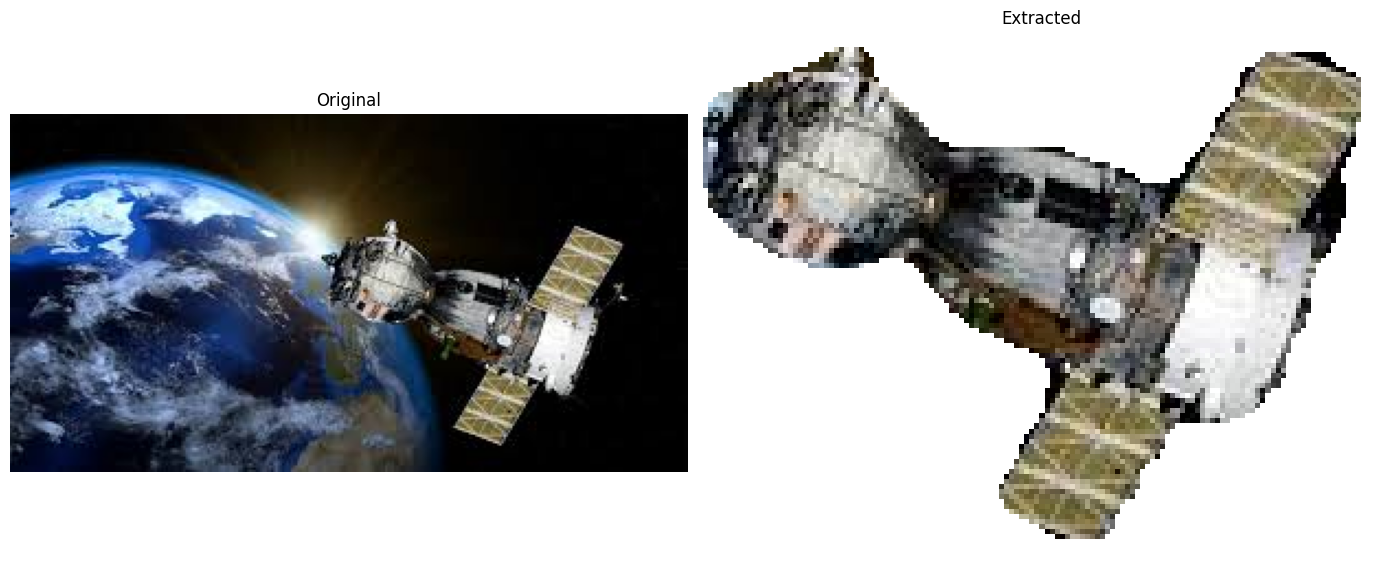

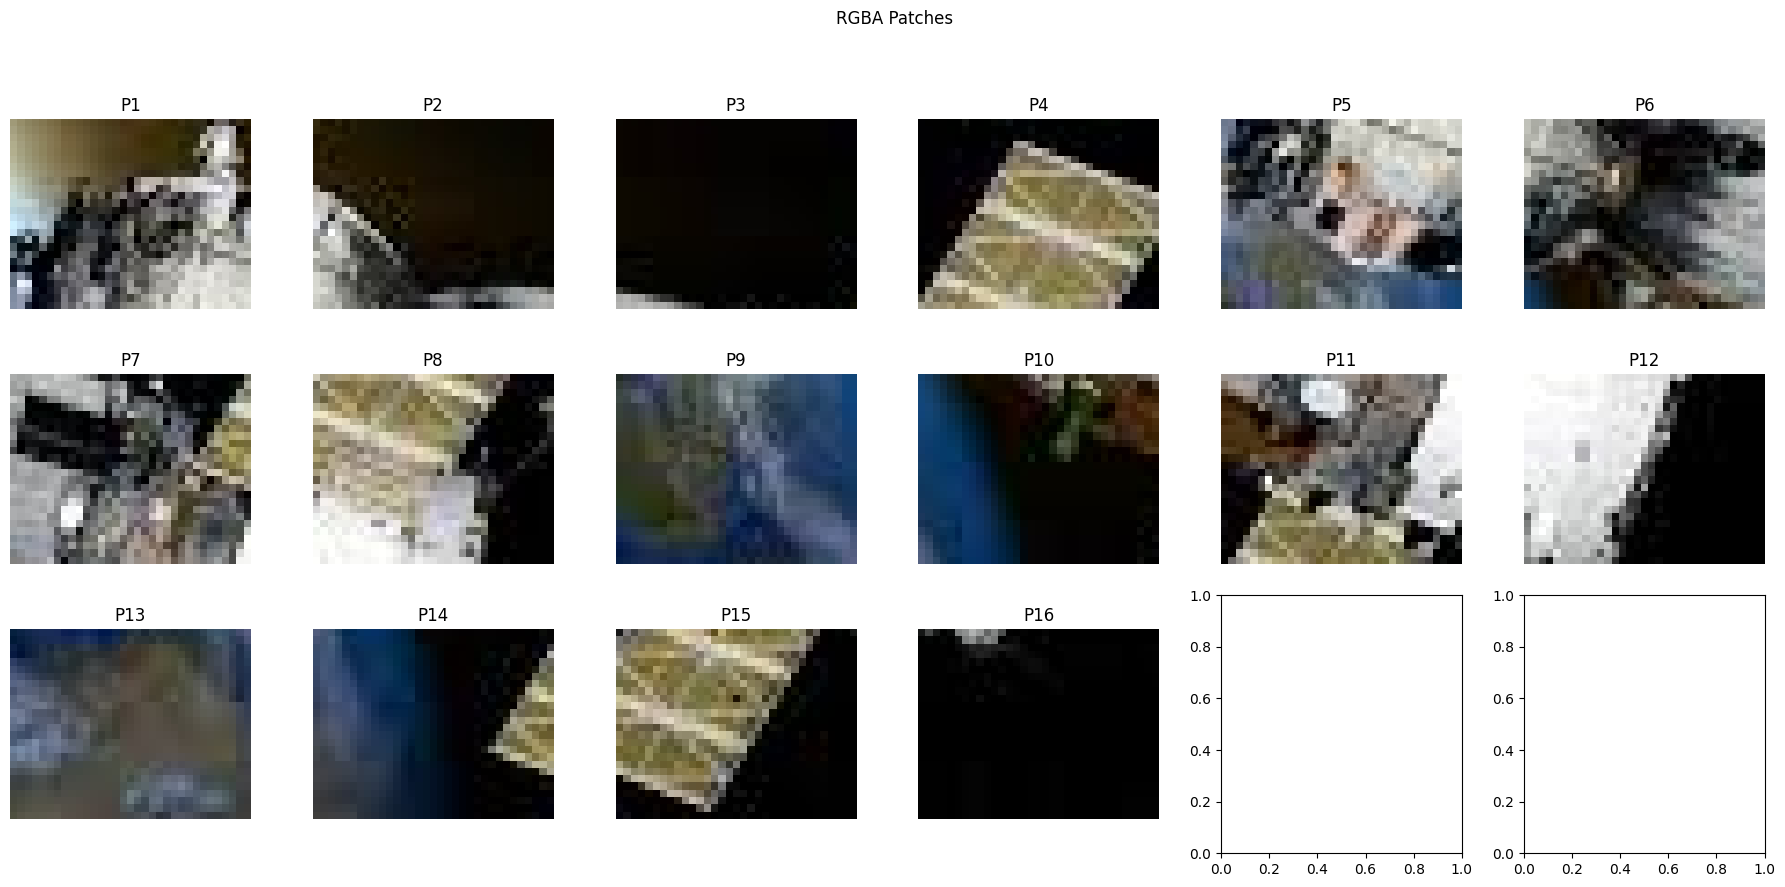

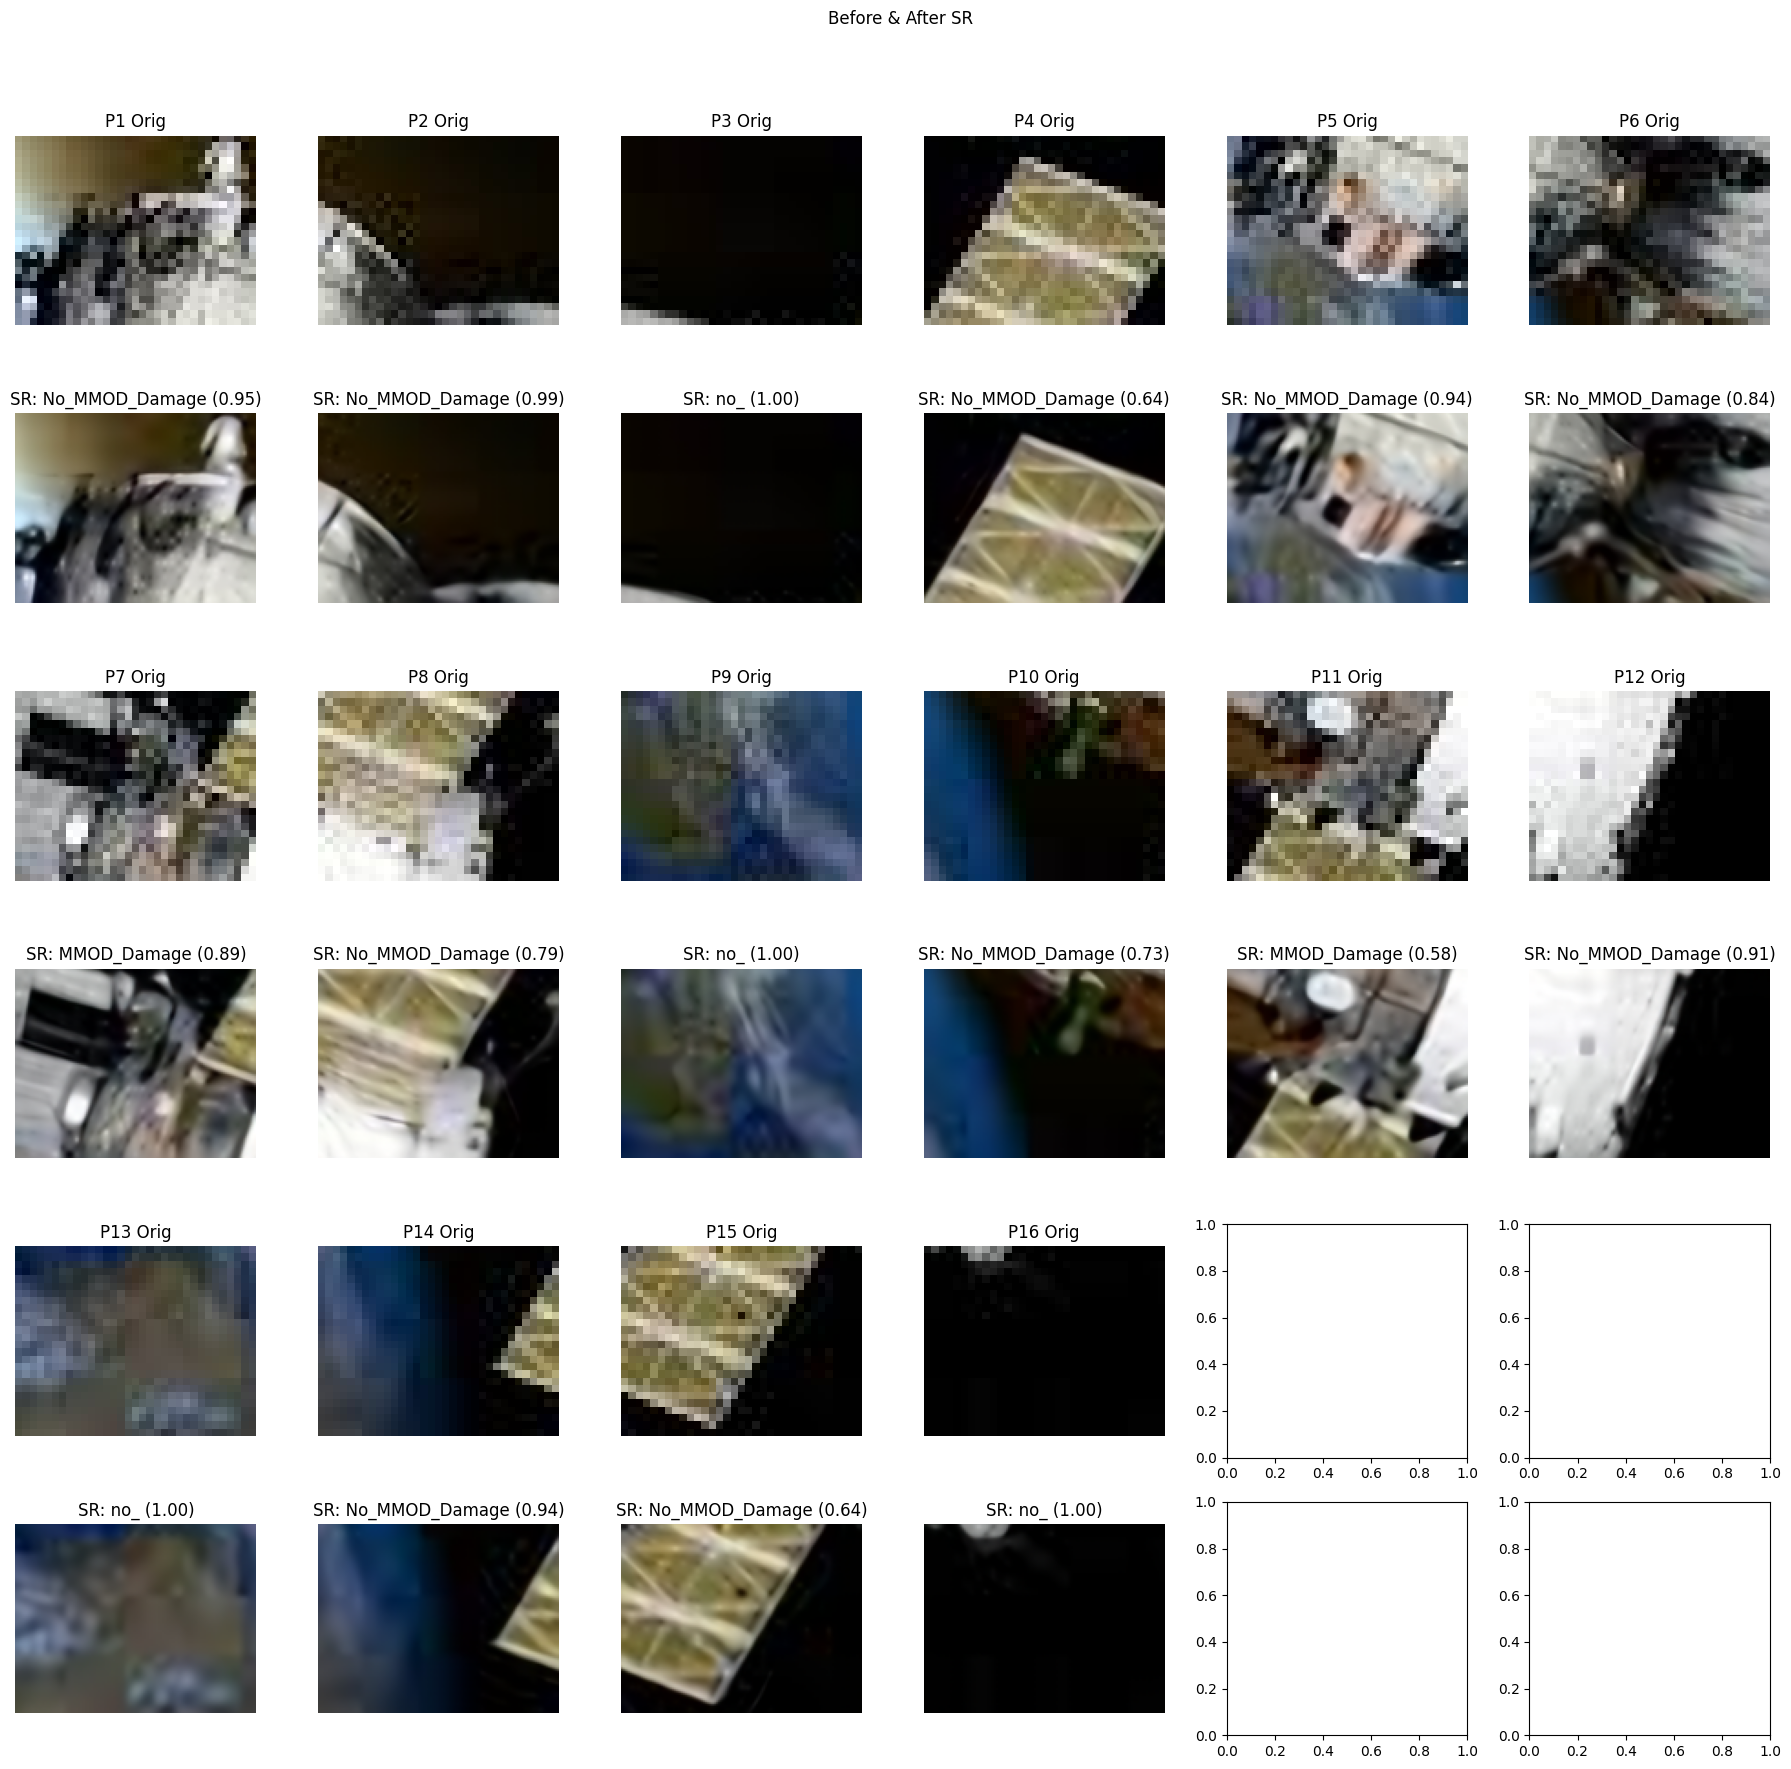

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


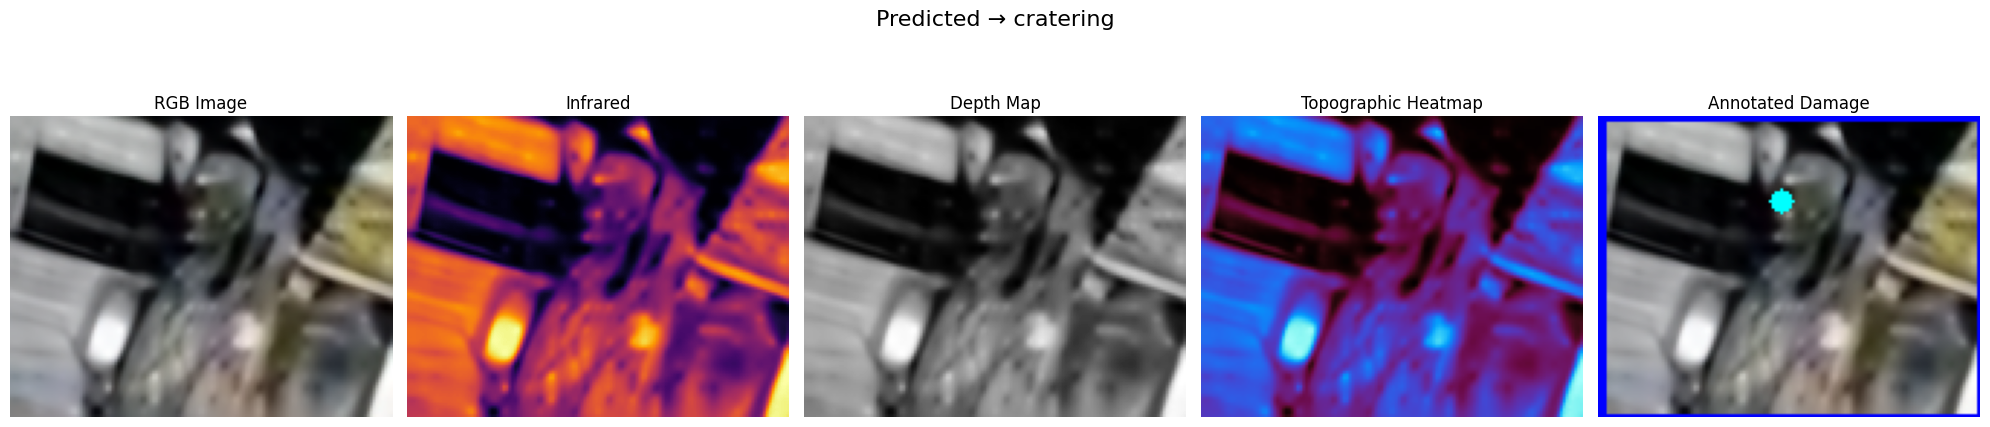

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


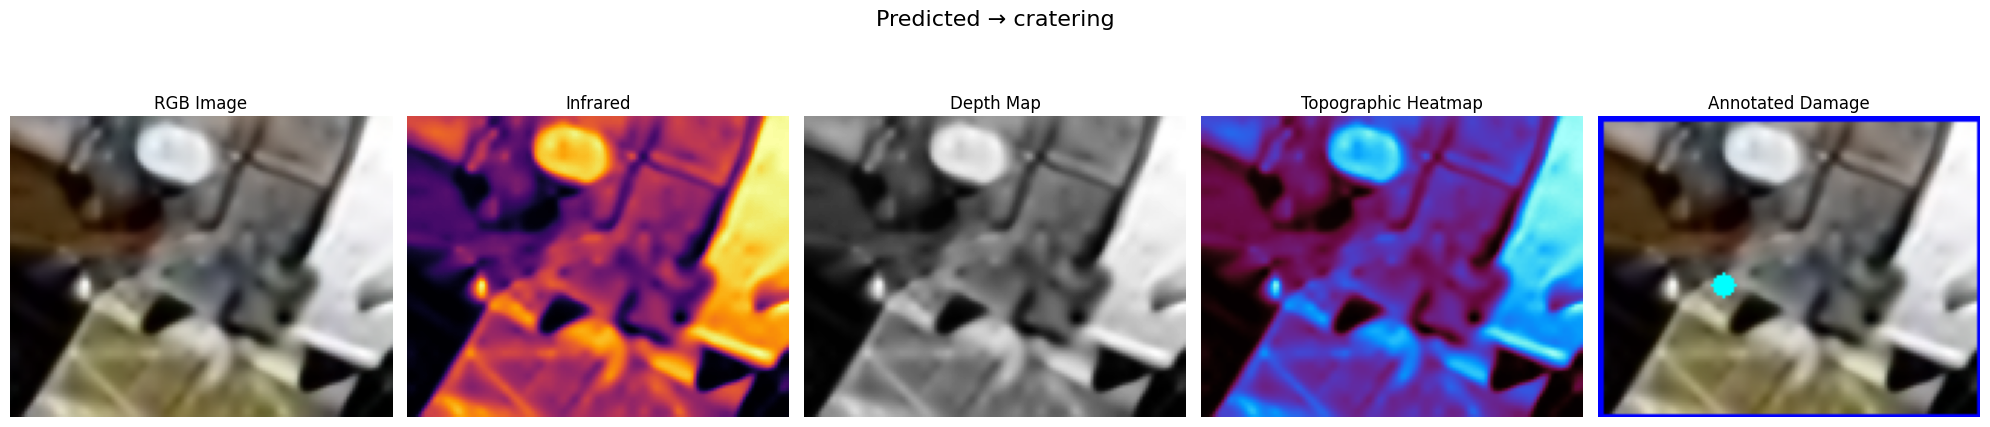


🏁 Done. Total SR time: 4.39s.


In [105]:
orig    = cv2.imread(img_path)[:,:,::-1]
outputs = predictor(orig)
boxes   = outputs["instances"].pred_boxes.tensor.cpu().numpy()
masks   = outputs["instances"].pred_masks.cpu().numpy()
print(f"Detected {len(boxes)} satellite(s).")

all_results=[]; total_sr_time=0.0

for i,(box,mask) in enumerate(zip(boxes,masks),start=1):
    print(f"\n--- Satellite #{i} ---")
    crop = extract_with_alpha(orig,box,mask)

    display_original_and_extracted(orig, crop)

    patches,coords = split_to_patches(crop)
    display_patches(patches)

    sr_list=[]
    for p in patches:
        t0=time.time()
        sp=superres_patch(p, sr)
        dt=time.time()-t0; total_sr_time+=dt
        lab,prob=classify_patches_sr([sp])
        sr_list.append((p,sp,lab[0],prob[0]))
    display_sr_grid([(o,s,lab,prob) for o,s,lab,prob in sr_list])

    for (o,s,lab,prob),coord in zip(sr_list,coords):
        if lab=="MMOD_Damage" :
            rgb_vis   = s[...,:3]
            ir_gray   = cv2.cvtColor(rgb_vis, cv2.COLOR_RGB2GRAY)
            depth_gray= ir_gray.copy()
            
            x, y, _, _ = coord
            out = predict_patch_with_h5(rgb_vis, ir_gray, depth_gray, (x, y))    
            
            h5_label   = h5_label_map[np.argmax(out)]
                
            display_multimodal(rgb_vis,ir_gray,depth_gray,h5_label)
            all_results.append({
                'sat_id':i, 'coord':coord,
                'fastai':lab, 'fastai_conf':prob,
                'h5':h5_label
            })

cv2.imwrite("/kaggle/working/final_output.jpg",
            cv2.cvtColor(orig,cv2.COLOR_RGB2BGR))

pd.DataFrame(all_results).to_csv("/kaggle/working/results.csv",index=False)

print(f"\n🏁 Done. Total SR time: {total_sr_time:.2f}s.")


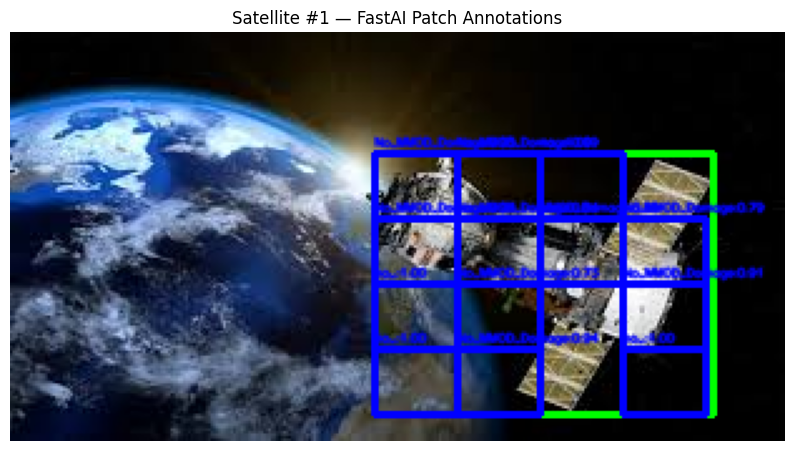

In [119]:
annot = orig.copy()  # Keep original RGB image
x1, y1, x2, y2 = map(int, box)  # Satellite bounding box

cv2.rectangle(annot, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Outline full satellite box

preds, probs = classify_patches_sr([superres_patch(p, sr) for p in patches])

for (x0, y0, x1p, y1p), pr, p_conf in zip(coords, preds, probs):
    if p_conf < 0.7:
        continue  # Skip low-confidence predictions
    px0, py0 = x1 + x0, y1 + y0
    px1, py1 = x1 + x1p, y1 + y1p
    color = (255, 0, 0) if pr == 'damage' else (0, 0, 255)
    cv2.rectangle(annot, (px0, py0), (px1, py1), color, 2)
    cv2.putText(annot, f"{pr}:{p_conf:.2f}",
            (px0, py0 - 3), cv2.FONT_HERSHEY_SIMPLEX,
            0.15, color, 1, cv2.LINE_AA)

# Optional: visualize annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annot)
plt.title(f"Satellite #{i} — FastAI Patch Annotations")
plt.axis('off')
plt.show()
